# Uniform vs non-uniform mesh size for a simple straigth crack : P0 vs P1 elements


Plane Elasticity problem 
Straight fracture in an infinite isotropic elastic medium  under uniform remote tension.

We explore the effect of using a spatiallyt non-uniform mesh size

In [1]:
# imports etc.
import sys
import os

from bigwham4py import BEMatrix
import numpy as np
from scipy.sparse.linalg import gmres

sys.path.append(os.path.join(os.getcwd(), '../..'))
from solutions.griffith_crack import width_griffith
import matplotlib.pyplot as plt


We set the elastic properties of the medium. Note that bigwham's input are the Young's modulus $E$ and Poisson's ratio $\nu$.

In [2]:
G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

# Uniform mesh vs randomized mesh
We define a function in order to solve the problem with a given number of elements. Either for P0 elements (constant displacement interpolation) or P1 elements (linear interpolation over the element but discontinuous between element).

In [3]:
def solveGriffith(nelts,a=1,kernel = "2DP0-H",uniform=True):
    """Wrapper function to solve the Griffith problem with a given number of elements + element type"""
    coor1D = np.linspace(-a, a, nelts + 1)
    if not(uniform) :
        # randomize the mesh size
        coor1D = np.linspace(-a, a, nelts + 1)
        h_uniform=2*a/nelts
        sampl =  np.random.uniform(low=-0.5*h_uniform, high=0.5*h_uniform, size=(nelts,))
        for i in range(1,nelts):
            coor1D[i]=coor1D[i]+sampl[i]
    coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)
    # H-matrix parameters - choosen here to have an accurate solution
    max_leaf_size=100
    eta=2.
    eps_aca=1.e-5
    elas_prop = np.array([E, nu])
    h = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca,n_openMP_threads=8)
    t = np.ones(h.shape[0])
    t[0::2] = 0.
    jac_ilu= h.H_ILU_prec() # we use a ILU decomposition of the full block for efficient solution via gmres
    d = gmres(h, t,M=jac_ilu,rtol=1e-6)[0]
    dd = d.reshape((-1, 2))
    col_pts = h.getMeshCollocationPoints()
    x_coor_=col_pts[:,0]
    # Crack opening displacement discontinuity from analytical solution 
    # note that 2DP1 segment have their solution at nodes.... 
    # note that 2DP1 segment have displacement disconinuity at element vertex for each element
    if (kernel =="2DP1-H"):
        x_coor_ = np.ones(2*nelts)
        for e in range(nelts):
            x_coor_[e*2:e*2+2]=coor1D[conn[e]]
    w_true=width_griffith(x_coor_,a=1,sig=1,G=1,nu=0.25)
    rmse = np.sqrt((np.sum(dd[:,1]-w_true)**2)/(w_true.size))
    l2rel = (np.linalg.norm((dd[:,1]-w_true)))/(np.linalg.norm(w_true))
    return x_coor_,dd,w_true,rmse,l2rel 

NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  3e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.001964
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-05, eta = 2
Hierarchical matrix  construction time = :  0.001991
--------------------
NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP0-H with properties size 2
-

Text(0.5, 1.0, 'width(x)')

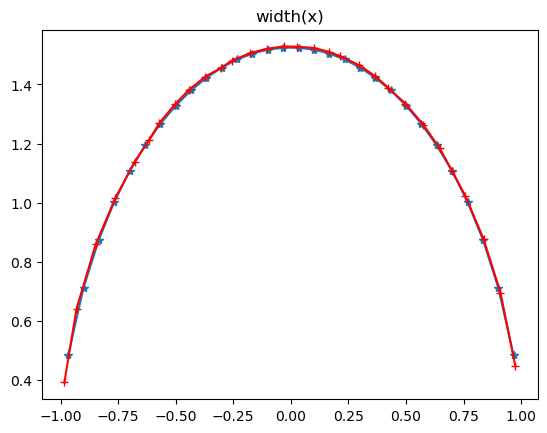

In [4]:
x_coor_U,dd_U,w_true_U,rmse_U,l2rel_U =solveGriffith(30,a=1,kernel = "2DP0-H",uniform=True)

x_coor_NU,dd_NU,w_true_NU,rmse_NU,l2rel_NU =solveGriffith(30,a=1,kernel = "2DP0-H",uniform=False)

plt.plot(x_coor_U, dd_U[:,1], "-*")
plt.plot(x_coor_NU, dd_NU[:,1], "-+r") 
plt.title('width(x)')


 Now setting things for kernel ... 2DP1-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.006829
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-05, eta = 2
Hierarchical matrix  construction time = :  0.006851
--------------------
 Now setting things for kernel ... 2DP1-H with properties size 2
--------------------
Hierarchical representation creation ...
Clust

Text(0.5, 1.0, 'width(x)')

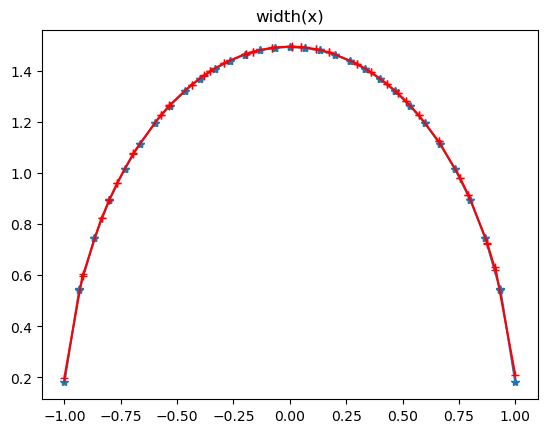

In [5]:
x_coor_U,dd_U,w_true_U,rmse_U,l2rel_U =solveGriffith(30,a=1,kernel = "2DP1-H",uniform=True)

x_coor_NU,dd_NU,w_true_NU,rmse_NU,l2rel_NU =solveGriffith(30,a=1,kernel = "2DP1-H",uniform=False)

plt.plot(x_coor_U, dd_U[:,1], "-*")
plt.plot(x_coor_NU, dd_NU[:,1], "-+r") 
plt.title('width(x)')

The results are acceptable -> which means that when meshing, if the size of the elements varies randomly within reasonable limits, we are ok. However, as we shall refinement is problematic

# Uniform vs tip refined !

In [6]:
# a factor 2 then 2 etc. refinement as we approach the tip
h_coarse=0.4
coor_xp = np.array([0.])
k=0
while coor_xp[k] < 1. :
    if  coor_xp[k] < 0.6 :
        d_x = h_coarse
    elif coor_xp[k] < 0.7 :
         d_x = h_coarse/2.
    elif coor_xp[k] < 0.8 :
         d_x = h_coarse/4.
    else:
        d_x = h_coarse/8.
    coor_xp=np.append(coor_xp,np.array([coor_xp[k]+d_x])).flatten()
    k=k+1

coor1D=np.unique(np.append(-coor_xp,coor_xp))
nelts=coor1D.size - 1
coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

kernel="2DP0-H"
# solution !
max_leaf_size=100
eta=2.
eps_aca=1.e-5
elas_prop = np.array([E, nu])
h = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca,n_openMP_threads=8)
t = np.ones(h.shape[0])
t[0::2] = 0.
jac_ilu= h.H_ILU_prec() # we use a ILU decomposition of the full block for efficient solution via gmres
d = gmres(h, t,M=jac_ilu,rtol=1e-6)[0]
dd = d.reshape((-1, 2))
col_pts = h.getMeshCollocationPoints()
x_coor_=col_pts[:,0]
    # Crack opening displacement discontinuity from analytical solution 
    # note that 2DP1 segment have their solution at nodes.... 
    # note that 2DP1 segment have displacement disconinuity at element vertex for each element
if (kernel =="2DP1-H"):
    x_coor_ = np.ones(2*nelts)
    for e in range(nelts):
        x_coor_[e*2:e*2+2]=coor1D[conn[e]]
w_true=width_griffith(x_coor_,a=1,sig=1,G=1,nu=0.25)



NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.000425
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-05, eta = 2
Hierarchical matrix  construction time = :  0.000444
--------------------


We compare the solution of such refinement with the solution using an uniform mesh ... of course with the same unumber of element.

NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.000414
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-05, eta = 2
Hierarchical matrix  construction time = :  0.000434
--------------------


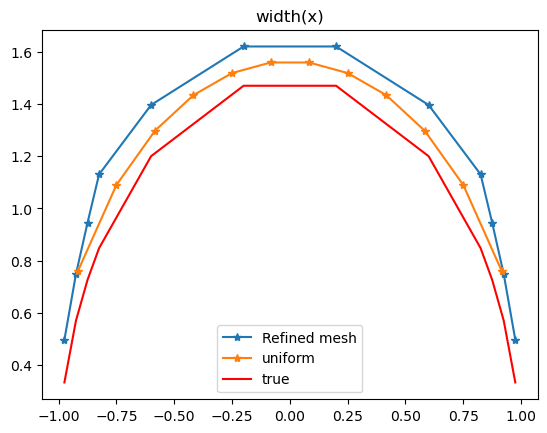

In [7]:
x_coor_U,dd_U,w_true_U,rmse_U,l2rel_U =solveGriffith(int(h.shape_[0]/2),a=1,kernel = "2DP0-H",uniform=True)

plt.plot(x_coor_, dd[:,1], "-*")
plt.plot(x_coor_U, dd_U[:,1], "-*")

plt.plot(x_coor_, w_true, "-r")

plt.title('width(x)')
plt.legend(['Refined mesh','uniform','true'])

... we see that the solution with an uniform mesh is better. Of course if the initial element size is reduced, it is better, but consistently the uniform mesh is better than the refined one.

If we use 2DP1 element, we can alleviate that.

NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP1-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.003739
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-05, eta = 2
Hierarchical matrix  construction time = :  0.003765
--------------------
NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP1-H with properties size 2
-

/Users/bricelecampion/ClionProjects/BigWham-Tutorials/examples/2d/../../solutions/griffith_crack.py:39: RuntimeWarning: invalid value encountered in sqrt
  return (sig*2*(1-nu)/G)*np.sqrt(a*a-x*x)


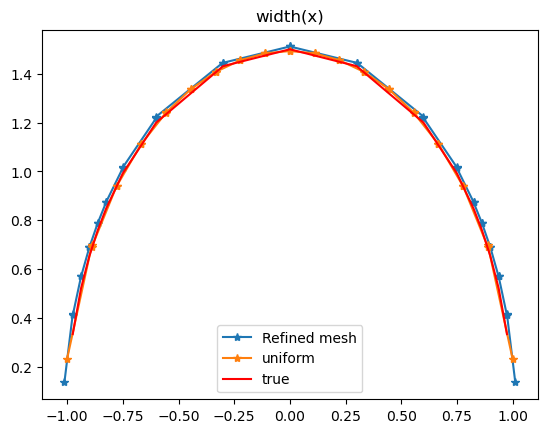

In [8]:
# a factor 2 then 2 etc. refinement as we approach the tip
h_coarse=0.3
coor_xp = np.array([0.])
k=0
while coor_xp[k] < 1. :
    if  coor_xp[k] < 0.6 :
        d_x = h_coarse
    elif coor_xp[k] < 0.7 :
         d_x = h_coarse/2.
    elif coor_xp[k] < 0.8 :
         d_x = h_coarse/4.
    else:
        d_x = h_coarse/8.
    coor_xp=np.append(coor_xp,np.array([coor_xp[k]+d_x])).flatten()
    k=k+1

coor1D=np.unique(np.append(-coor_xp,coor_xp))
nelts=coor1D.size - 1
coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

kernel="2DP1-H"
# solution !
max_leaf_size=100
eta=2.
eps_aca=1.e-5
elas_prop = np.array([E, nu])
h = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)
t = np.ones(h.shape[0])
t[0::2] = 0.
jac_ilu= h.H_ILU_prec() # we use a ILU decomposition of the full block for efficient solution via gmres
d = gmres(h, t,M=jac_ilu,rtol=1e-6)[0]
dd = d.reshape((-1, 2))
col_pts = h.getMeshCollocationPoints()
x_coor_=col_pts[:,0]
    # Crack opening displacement discontinuity from analytical solution 
    # note that 2DP1 segment have their solution at nodes.... 
    # note that 2DP1 segment have displacement disconinuity at element vertex for each element
if (kernel =="2DP1-H"):
    x_coor_ = np.ones(2*nelts)
    for e in range(nelts):
        x_coor_[e*2:e*2+2]=coor1D[conn[e]]
w_true=width_griffith(x_coor_,a=1,sig=1,G=1,nu=0.25)

x_coor_U,dd_U,w_true_U,rmse_U,l2rel_U =solveGriffith(int(h.shape_[0]/4),a=1,kernel = "2DP1-H",uniform=True)

plt.plot(x_coor_, dd[:,1], "-*")
plt.plot(x_coor_U, dd_U[:,1], "-*")

plt.plot(x_coor_, w_true, "-r")

plt.title('width(x)')
plt.legend(['Refined mesh','uniform','true'])

## Take home messages

 - Small variation of element sizes (within an average uniform mesh size) are acceptable for P0 elements (P1 are better though) - here the mesh size is 'still' roughly uniform over the domain,
 - Refinement toward the tip by decreasing mesh size by 2 results in globally poorer results for P0 elements compared to uniform mesh. However, with P1 elements, refinement yields  very good results. 